# Stereoisomer testing on ChiENN - stellungsisomere

## Importing section

In [1]:
import numpy as np
from rdkit import Chem
from rdkit.Chem import AllChem
import sys

sys.path.append("../../../../")

from ptgnn.features.chienn.mol_to_data import mol_to_data
from ptgnn.features.chienn.molecule3d import smiles_to_3d_mol
from ptgnn.transform import edge_graph_transform

## Define SMILES strings

In [2]:
smiles_list = [
    "CC(Cl)(Cl)C",
    "C(Cl)C(Cl)C",
    "ClCCCCl",
    
    "OC(=O)C(N)CC",
    "OC(=O)CC(N)C",
    "OC(=O)CCCN",
    
    "C1C=CC=C(Cl)C=1Cl",
    "ClC1C=CC=C(Cl)C=1",
    "ClC1C=CC(Cl)=CC=1",
]

## Visualize and confirm stereomer classification (E/Z)

In [3]:
def showAndChiral(smiles):
    mol = Chem.MolFromSmiles(smiles)
    display(mol)
    print(AllChem.FindMolChiralCenters(mol))
    for bond in mol.GetBonds():
        if bond.GetBondType() == Chem.rdchem.BondType.DOUBLE:
            print("Bond", bond.GetIdx(), "stereo:", bond.GetStereo())

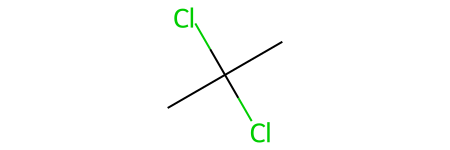

[]


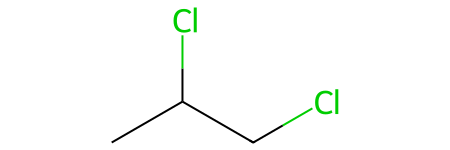

[]


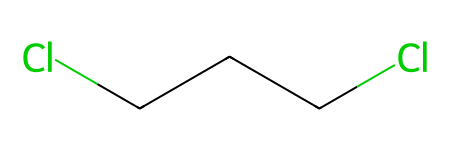

[]


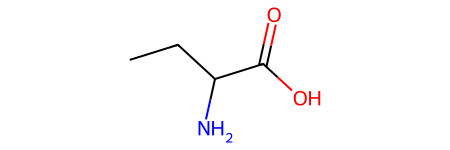

[]
Bond 1 stereo: STEREONONE


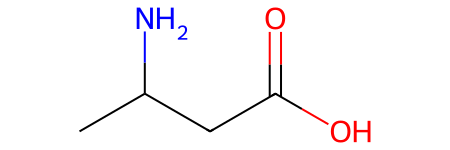

[]
Bond 1 stereo: STEREONONE


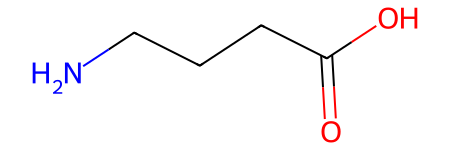

[]
Bond 1 stereo: STEREONONE


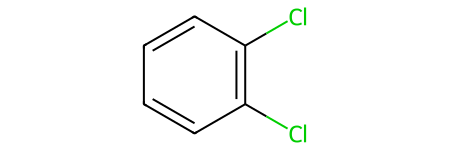

[]


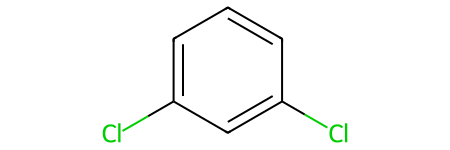

[]


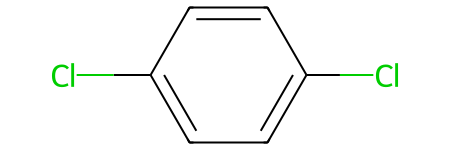

[]


In [4]:
for smile in smiles_list:
    showAndChiral(smile)

##  Convert to (edge) graph with ptree

In [5]:
# get molecules
mol_list = [
    smiles_to_3d_mol(
        smiles,
        max_number_of_attempts=100,
        max_number_of_atoms=100
    )
    for smiles in smiles_list
]

In [6]:
data_list = [
    mol_to_data(mol)
    for mol in mol_list
]

In [7]:
data_list = [
    edge_graph_transform(
        data,
        transformation_mode="permutation_tree",
        mol=mol,
        transformation_parameters={
            'k':  3,
            'tetrahedral_chiral': True,
            'chiral_center_selective': True,
            'chiral_center_select_potential': False,
        }
    )
    for data, mol in zip(data_list, mol_list)
]

In [8]:
for data in data_list:
    print(data)
    print(data.ptree)

Data(x=[20, 93], edge_index=[2, 56], edge_attr=[56, 57], pos=[20, 6], parallel_node_index=[20], circle_index=[20], ptree=[20], initial_map=[76], layer0_order_matrix=[1], layer0_type_mask=[1], layer0_pooling=[1], num_layer=2, layer1_order_matrix=[1], layer1_type_mask=[1], layer1_pooling=[1])
['{"S": [0, 1, {"P": [3, 7, 5]}]}', '{"S": [1, 0, {"P": [9, 11, 13]}]}', '{"S": [2, 3, {"P": [1, 5, 7]}]}', '{"S": [3, 2]}', '{"S": [4, 5, {"P": [1, 7, 3]}]}', '{"S": [5, 4]}', '{"S": [6, 7, {"P": [1, 3, 5]}]}', '{"S": [7, 6]}', '{"S": [8, 9, {"P": [0, 13, 11]}]}', '{"S": [9, 8, {"P": [15, 19, 17]}]}', '{"S": [10, 11, {"P": [0, 9, 13]}]}', '{"S": [11, 10]}', '{"S": [12, 13, {"P": [0, 11, 9]}]}', '{"S": [13, 12]}', '{"S": [14, 15, {"P": [8, 17, 19]}]}', '{"S": [15, 14]}', '{"S": [16, 17, {"P": [8, 19, 15]}]}', '{"S": [17, 16]}', '{"S": [18, 19, {"P": [8, 15, 17]}]}', '{"S": [19, 18]}']
Data(x=[20, 93], edge_index=[2, 56], edge_attr=[56, 57], pos=[20, 6], parallel_node_index=[20], circle_index=[20], p

## Create Model

In [9]:
import torch
from ptgnn.model.modules.custom_wrapper import CustomWrapper
from ptgnn.model.modules.ptree.advanced_tree_layer import AdvancedPermutationTreeLayer

k = 3

modules_list = [
    CustomWrapper(AdvancedPermutationTreeLayer(
        hidden_dim=93,
        k=k,
        apply_p_elu=True
    ))
    for _ in range(2)
] + [
    AdvancedPermutationTreeLayer(
        hidden_dim=93,
        k=k,
        apply_p_elu=True
    )
]

model = torch.nn.Sequential(
    *modules_list
)
model

Sequential(
  (0): CustomWrapper(
    (layer_to_wrap): AdvancedPermutationTreeLayer(
      (p_layer): Linear(in_features=93, out_features=93, bias=False)
      (p_final_layer): Linear(in_features=93, out_features=93, bias=False)
      (p_elu): ELU(alpha=1.0)
      (z_layer): ModuleList(
        (0-2): 3 x Linear(in_features=93, out_features=93, bias=False)
      )
      (z_final_layer): Linear(in_features=93, out_features=93, bias=False)
      (s_layer): ModuleList(
        (0-2): 3 x Linear(in_features=93, out_features=93, bias=False)
      )
      (s_final_layer): Linear(in_features=93, out_features=93, bias=False)
      (z2_layer): ModuleList(
        (0-2): 3 x Linear(in_features=93, out_features=93, bias=False)
      )
      (z2_final_layer): Linear(in_features=93, out_features=93, bias=False)
      (s2_layer): ModuleList(
        (0-2): 3 x Linear(in_features=93, out_features=93, bias=False)
      )
      (s2_final_layer): Linear(in_features=93, out_features=93, bias=False)
     

## Create batches

In [10]:
from ptgnn.loading.collate import permutation_tree_collation

batch_list = [
    permutation_tree_collation([data])
    for data in data_list
]

In [11]:
# compare output
display(np.array(
    [
        [
            (batch_list[i].x == batch_list[j].x).all() if batch_list[i].x.shape == batch_list[j].x.shape else np.nan
            for j in range(len(batch_list))
        ]
        for i in range(len(batch_list))
    ]
))

array([[ 1.,  0.,  0., nan, nan, nan, nan, nan, nan],
       [ 0.,  1.,  0., nan, nan, nan, nan, nan, nan],
       [ 0.,  0.,  1., nan, nan, nan, nan, nan, nan],
       [nan, nan, nan,  1.,  0.,  0., nan, nan, nan],
       [nan, nan, nan,  0.,  1.,  0., nan, nan, nan],
       [nan, nan, nan,  0.,  0.,  1., nan, nan, nan],
       [nan, nan, nan, nan, nan, nan,  1.,  0.,  0.],
       [nan, nan, nan, nan, nan, nan,  0.,  1.,  0.],
       [nan, nan, nan, nan, nan, nan,  0.,  0.,  1.]])

## Put batches through model

In [12]:
out_list = [
    model(batch)
    for batch in batch_list
]

## Compare batches

In [13]:
# compare output
display(np.array(
    [
        [
            (out_list[i] == out_list[j]).all() if out_list[i].shape==out_list[j].shape else np.nan
            for j in range(len(out_list))
        ]
        for i in range(len(out_list))
    ]
))

array([[ 1.,  0.,  0., nan, nan, nan, nan, nan, nan],
       [ 0.,  1.,  0., nan, nan, nan, nan, nan, nan],
       [ 0.,  0.,  1., nan, nan, nan, nan, nan, nan],
       [nan, nan, nan,  1.,  0.,  0., nan, nan, nan],
       [nan, nan, nan,  0.,  1.,  0., nan, nan, nan],
       [nan, nan, nan,  0.,  0.,  1., nan, nan, nan],
       [nan, nan, nan, nan, nan, nan,  1.,  0.,  0.],
       [nan, nan, nan, nan, nan, nan,  0.,  1.,  0.],
       [nan, nan, nan, nan, nan, nan,  0.,  0.,  1.]])

In [14]:
# compare sum pooled version itself
display(np.array(
    [
        [
            out_list[i].sum().item() - out_list[j].sum().item()
            for j in range(len(out_list))
        ]
        for i in range(len(out_list))
    ]
) == 0)

array([[ True, False, False, False, False, False, False, False, False],
       [False,  True, False, False, False, False, False, False, False],
       [False, False,  True, False, False, False, False, False, False],
       [False, False, False,  True, False, False, False, False, False],
       [False, False, False, False,  True, False, False, False, False],
       [False, False, False, False, False,  True, False, False, False],
       [False, False, False, False, False, False,  True, False, False],
       [False, False, False, False, False, False, False,  True, False],
       [False, False, False, False, False, False, False, False,  True]])

In [15]:
# compare sum pooled version itself
display(np.array(
    [
        [
            out_list[i].sum().item() - out_list[j].sum().item()
            for j in range(len(out_list))
        ]
        for i in range(len(out_list))
    ]
))

array([[ 0.00000000e+00, -6.69408441e-02, -1.41296029e-01,
         2.74557424e+00,  2.82726479e+00,  2.76101899e+00,
         5.30265737e+00,  5.30630469e+00,  5.30586982e+00],
       [ 6.69408441e-02,  0.00000000e+00, -7.43551850e-02,
         2.81251508e+00,  2.89420563e+00,  2.82795984e+00,
         5.36959821e+00,  5.37324554e+00,  5.37281066e+00],
       [ 1.41296029e-01,  7.43551850e-02,  0.00000000e+00,
         2.88687027e+00,  2.96856081e+00,  2.90231502e+00,
         5.44395339e+00,  5.44760072e+00,  5.44716585e+00],
       [-2.74557424e+00, -2.81251508e+00, -2.88687027e+00,
         0.00000000e+00,  8.16905499e-02,  1.54447556e-02,
         2.55708313e+00,  2.56073046e+00,  2.56029558e+00],
       [-2.82726479e+00, -2.89420563e+00, -2.96856081e+00,
        -8.16905499e-02,  0.00000000e+00, -6.62457943e-02,
         2.47539258e+00,  2.47903991e+00,  2.47860503e+00],
       [-2.76101899e+00, -2.82795984e+00, -2.90231502e+00,
        -1.54447556e-02,  6.62457943e-02,  0.000000

In [16]:
# compare output
display(np.array(
    [
        [
            (out_list[i] - out_list[j]).detach().abs().sum() if batch_list[i].x.shape == batch_list[j].x.shape else np.nan
            for j in range(len(out_list))
        ]
        for i in range(len(out_list))
    ]
))

array([[ 0.        , 15.64907265, 21.77226257,         nan,         nan,
                nan,         nan,         nan,         nan],
       [15.64907265,  0.        , 18.79875183,         nan,         nan,
                nan,         nan,         nan,         nan],
       [21.77226257, 18.79875183,  0.        ,         nan,         nan,
                nan,         nan,         nan,         nan],
       [        nan,         nan,         nan,  0.        , 30.71880722,
        40.98466492,         nan,         nan,         nan],
       [        nan,         nan,         nan, 30.71880722,  0.        ,
        33.35697556,         nan,         nan,         nan],
       [        nan,         nan,         nan, 40.98466492, 33.35697556,
         0.        ,         nan,         nan,         nan],
       [        nan,         nan,         nan,         nan,         nan,
                nan,  0.        , 12.81610489, 13.06569862],
       [        nan,         nan,         nan,         nan,   

Distinguishes properly (twice equal value - repeated until different)